# Libraries

In [1]:
import numpy as np
import cv2
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Torch libraries
import torch
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torch.nn.functional as F

## Random Seed

In [2]:
seed_value = 42

np.random.seed(seed_value)  # NumPy
torch.manual_seed(seed_value)  # PyTorch CPU
torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU

# Data Manager

In [ ]:
def equalise_image(image):
   gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   equalized_image = cv2.equalizeHist(gray_image)
   equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_GRAY2BGR)

   return equalized_image

Defines a custom dataset class

In [3]:
class CustomDataset(Dataset):
   def __init__(self, images, labels, transform=None):
      self.images = images
      self.labels = labels
      self.transform = transform

   def __len__(self):
      return len(self.images)

   def __getitem__(self, idx):
      image = self.images[idx]
      imageResize = cv2.resize(image, (299, 299))

      label = self.labels[idx]
      if self.transform:
         imageResize = self.transform(imageResize)
      return imageResize, label

In [4]:
def load_images_with_masks(image_directory, mask_directory):
    images = []
    labels = []
    for image_filename in os.listdir(image_directory):
        if image_filename.endswith(".tif"):
            image_filepath = os.path.join(image_directory, image_filename)
            mask_filename = image_filename + '.png'
            mask_filepath = os.path.join(mask_directory, mask_filename)
            try:
                image = cv2.imread(image_filepath)
				# image = equalise_image(image)
                mask = cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(mask)
            except Exception as e:
                print(f"Error loading image {image_filename} or mask: {e}")
    return np.array(images), np.array(labels)

In [5]:
def extract_subimages(images, labels, removeIndex, subimage_size=64, step_size=8):
    subimages = []
    sublabels = []
    for i in range(len(images)):
        if i != removeIndex: #skip the image used for testing
            image = images[i]
            label = labels[i]
            height, width = image.shape[:2]
            for y in range(0, height - subimage_size + 1, step_size):
                for x in range(0, width - subimage_size + 1, step_size):
                    subimage = image[y:y+subimage_size, x:x+subimage_size]
                    sublabel = label[y:y+subimage_size, x:x+subimage_size]
                    if np.all(sublabel == 0) or np.all(sublabel == 255):
                        subimages.append(subimage)
                        sublabels.append(sublabel[0][0])  # Assuming all values are the same in the sublabel
    return np.array(subimages), np.array(sublabels)

In [6]:
def pick_items_with_probability(list1, list2, n, p):
  # Calculate the number of items to pick from each list based on probability p
  num_items_list1 = int(n * p)
  num_items_list2 = n - num_items_list1

  # Select items from each list based on probability
  selected_items_list1 = random.choices(list1, k=num_items_list1)
  selected_items_list2 = random.choices(list2, k=num_items_list2)

  return selected_items_list1, selected_items_list2

In [7]:
def create_dataloader(batch_size=100, n=60000, p=0.66):

   image_directory = "neuroendocrine_/images"
   mask_directory = "neuroendocrine_/masks"

   images, labels = load_images_with_masks(image_directory, mask_directory)
   train_images, train_labels = extract_subimages(images[:-1], labels, 29)
   val_images, val_labels = extract_subimages(images[-1:], labels, -1)

   val_images = val_images[:100]
   val_labels = val_labels[:100]

   print("Shape of the train_images array:", train_images.shape)
   print("Shape of the train_labels array:", train_labels.shape)
   print("Shape of the val_labels array:", val_images.shape)
   print("Shape of the val_labels array:", val_labels.shape)

   # labels should be 0 or 1
   train_labels[train_labels == 255] = 1
   val_labels[val_labels == 255] = 1

   del images
   del labels

   # Assuming train_images and train_labels are your training data
   # Calculate the indices of each class
   class_0_indices = np.where(train_labels == 0)[0]
   class_1_indices = np.where(train_labels == 1)[0]

   # Determine the size of the minority class
   minority_class_size = len(class_0_indices)

   # Randomly sample the same number of samples from the majority class
   # undersampled_class_1_indices = np.random.choice(class_1_indices, minority_class_size, replace=False)

   class_0_indices, undersampled_class_1_indices = pick_items_with_probability(class_0_indices, class_1_indices, n, p)

   del class_1_indices
   del minority_class_size

   # Concatenate the indices of both classes
   undersampled_indices = np.concatenate([class_0_indices, undersampled_class_1_indices])

   del class_0_indices
   del undersampled_class_1_indices

   # Shuffle the indices to mix the samples from both classes
   np.random.shuffle(undersampled_indices)

   # Use the undersampled indices to create a new balanced dataset
   undersampled_images = train_images[undersampled_indices]
   undersampled_labels = train_labels[undersampled_indices]

   print("Shape of the train_images array:", undersampled_images.shape)
   print("Shape of the train_labels array:", undersampled_labels.shape)

   del train_images
   del train_labels

   del undersampled_indices

   # Define transformations for resizing and normalization
   transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

   # Create the undersampled dataset
   undersampled_dataset = CustomDataset(undersampled_images, undersampled_labels, transform=transform)
   val_dataset = CustomDataset(val_images, val_labels, transform=transform)

   del undersampled_images
   del undersampled_labels

   # Create the data loader for the undersampled dataset
   undersampled_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True)
   val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

   del undersampled_dataset

   return undersampled_loader, val_loader

In [8]:
def get_images(dataset_path, test=False):

   suff = None

   if test == False:
      suff = "images"
   else:
      suff = "masks"

   images_dir_path = Path(f"{dataset_path}/{suff}")

   # List all files in the folder
   images_paths = sorted(list(images_dir_path.iterdir()))

   return images_paths

# Models Manager

In [9]:
def focal_loss(outputs, labels):

  alpha = 1
  gamma = 2
  # Convert labels to int64 type
  labels = labels.long()

  # Compute class weights based on the frequency of each class in the labels
  class_counts = torch.bincount(labels)

  class_weights = (1 / class_counts.float()).clone().detach()

  # Normalize the class weights
  class_weights /= class_weights.sum()

  # Compute softmax along the class dimension
  input_softmax = F.softmax(outputs, dim=1)
  # Gather the probabilities of the true class
  p_t = torch.gather(input_softmax, 1, labels.view(-1, 1))
  # Compute binary cross entropy loss
  bce_loss = F.cross_entropy(outputs, labels, reduction='none')
  # Compute focal loss
  focal_loss = alpha * (1 - p_t) ** gamma * bce_loss
  return torch.mean(focal_loss)

In [10]:
def import_model(model_name):
  if model_name == "inceptionv3":
    # Load InceptionV3 model pretrained on ImageNet
    model = models.inception_v3(weights='DEFAULT')
  elif model_name == "AlexNet":
    # Load AlexNet model pretrained on ImageNet
    model = models.alexnet(weights='DEFAULT')

  return model

In [11]:
def setup_model(model, device):
  # Set the model to evaluation mode
  model.eval()

  num_classes = 2  # Assuming CustomDataset has a 'classes' attribute

  if isinstance(model, models.inception.Inception3):
    # Freeze all the parameters
    for param in model.parameters():
      param.requires_grad = False

    # Modify the last layer to fit your number of classes
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, num_classes)
        )

  elif isinstance(model, models.AlexNet):
    model.classifier.add_module('7', nn.ReLU())
    model.classifier.add_module('8', nn.Linear(1000, 512))
    model.classifier.add_module('9', nn.ReLU())
    model.classifier.add_module('10', nn.Linear(512, 128))
    model.classifier.add_module('11', nn.ReLU())
    model.classifier.add_module('12', nn.Linear(128, 32))
    model.classifier.add_module('13', nn.ReLU())
    model.classifier.add_module('14', nn.Linear(32, 2))

  # Move the model to the GPU
  model = model.to(device)

In [12]:
  def setup_training(model):

    if isinstance(model, models.inception.Inception3):
      model.fc.train()

    elif isinstance(model, models.AlexNet):
      model.train()

In [13]:
def validate(model, criterion, dataloader, device):

  val_loss = 0.0
  correct_predictions = 0
  total_samples = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    val_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

  val_loss /= total_samples
  accuracy = correct_predictions / total_samples

  print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

### Training loop

In [14]:
def training_loop(model, optimizer, criterion, train_dataloader, val_dataloader, device,
                  num_epochs, max_train, print_every):

  for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_dataloader, 1):

      # Fetch inputs and labels
      inputs, labels = inputs.to(device), labels.to(device)

      # Initialise gradients
      optimizer.zero_grad()

      # Feedforward
      outputs = model(inputs)

      # Backpropagate
      loss = criterion(outputs, labels)
      loss.backward()

      # Update parameters
      optimizer.step()

      # Append loss
      running_loss += loss.item() * inputs.size(0)

      # Print average loss every print_every iterations
      if i % print_every == 0:
        epoch_loss = running_loss / (print_every * len(inputs))
        print(f"Iteration [{i}/{len(train_dataloader)}], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        running_loss = 0.0
        validate(model, criterion, val_dataloader, device)
        print("------------------")

      # Iteration limit
      if i >= max_train:
        break

    print("==========================")

In [15]:
def train(model, optimizer, dataloader, val_dataloader, class_weights, device,
          num_epochs=1, max_train=200, print_every=10):

  setup_training(model)

  # criterion = nn.CrossEntropyLoss()

  class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

  # Define your loss function with custom class weights
  criterion = nn.CrossEntropyLoss(weight=class_weights)
  # criterion = focal_loss

  training_loop(model, optimizer, criterion, dataloader, val_dataloader, device, num_epochs, max_train, print_every)

In [16]:
def load_params(model, local_path, project_path, version, device):

  model_path = None
  params_path = None

  if isinstance(model, models.inception.Inception3):

    model_path = "inception_v3"
    params_path = "incv3_params.pth"

  elif isinstance(model, models.AlexNet):

    model_path = "AlexNet"
    params_path = "AlexNet_params.pth"

  full_path = f"{local_path}/{params_path}"

  if not os.path.exists(params_path):
    # if there are no local parameters, load the selected ones
    full_path = f"{project_path}/{model_path}/{version}/{params_path}"

  # Load the saved dictionary into your model
  state_dict = torch.load(full_path, map_location=device)
  model.load_state_dict(state_dict)

In [17]:
def save_params(model, local_path):

  params_path = None

  if isinstance(model, models.inception.Inception3):
    params_path = "incv3_params.pth"

  elif isinstance(model, models.AlexNet):
    params_path = "AlexNet_params.pth"

  # Save the model state
  torch.save(model.state_dict(), f"{local_path}/{params_path}")

In [18]:
def predict(model, device, image):

  testImage = image

  subimage_size = 64
  step_size = 8

  height, width = testImage.shape[:2]
  outputHeight = height - height % step_size
  outputWidth = width - width % step_size
  tumorCount = np.zeros((outputHeight, outputWidth))
  count = np.zeros((outputHeight, outputWidth))

  # Move model to GPU
  model.eval()

  for row in range(0, height - subimage_size + 1, step_size):
    if row % 50 == 0:
      print('Row ' + str(row) + '/ ' + str(height))
    for col in range(0, width - subimage_size + 1, step_size):
      subimage = testImage[row:row+subimage_size, col:col+subimage_size]

      # Prepare subimage for InceptionV3
      # Resize the subimage using OpenCV
      resized_subimage = cv2.resize(subimage, (299, 299))

      # Define the transformations
      transform = transforms.Compose([
          transforms.ToTensor(),  # Convert image to tensor
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
          ])

      # Apply the transformations and move to GPU
      transformed_subimage = transform(resized_subimage).to(device)

      # Compute output on GPU
      with torch.no_grad():
        output = model(transformed_subimage.unsqueeze(0))
        label = torch.argmax(output)

      # Write to matrix
      if label == 1:
        tumorCount[row:row+subimage_size, col:col+subimage_size] += 1
      count[row:row+subimage_size, col:col+subimage_size] += 1

  # Calculate average tumor occurrence per submatrix
  avg = np.divide(tumorCount, count)

  return avg

In [19]:
def get_prediction(model, local_path, project_path, version):

  if isinstance(model, models.inception.Inception3):
    model_name = "inception_v3"

  elif isinstance(model, models.AlexNet):
    model_name = "AlexNet"

  if os.path.exists("avg.png"):
    avg_path = f"{local_path}/avg.png"
  else:
    avg_path = f"{project_path}/{model_name}/{version}/avg.png"

  avg = cv2.imread(avg_path)

  # Convert the image to grayscale
  avg = cv2.cvtColor(avg, cv2.COLOR_BGR2GRAY)
  avg = avg/255

  return avg

In [20]:
def beautify_output(avg):
  printAvg = avg*255
  return printAvg

In [21]:
def threshold_output(avg, thr=0.5):
  modelGuess = np.where(avg >= thr, 255, 0).astype(np.uint8)[:1283, :2040]
  return modelGuess

In [22]:
def visualise_output(printable):
  # Displaying the numpy array as grayscale
  plt.imshow(printable, cmap='gray', vmin=0, vmax=255)  # Specify vmin and vmax
  plt.axis('off')  # Turn off axis
  plt.show()

In [23]:
def save_prediction(pred):
  cv2.imwrite('pred_image.png', pred)

# Evaluation Manager

In [24]:
def pixel_accuracy(y_true, y_pred):

  return accuracy_score(y_true.flatten(), y_pred.flatten())

def pixel_precision(y_true, y_pred):

  true_positives = np.sum(np.logical_and(y_true, y_pred))
  false_positives = np.sum(np.logical_and(np.logical_not(y_true), y_pred))

  if true_positives + false_positives == 0:
    return 0.0
  else:
    return true_positives / (true_positives + false_positives)

def pixel_recall(y_true, y_pred):

  true_positives = np.sum(np.logical_and(y_true, y_pred))
  false_negatives = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))

  if true_positives + false_negatives == 0:
    return 0.0
  else:
    return true_positives / (true_positives + false_negatives)

def intersection_over_union(y_true, y_pred):

  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  return np.sum(intersection) / np.sum(union)

def dice_coefficient(y_true, y_pred):

  intersection = np.logical_and(y_true, y_pred)

  return 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))

In [25]:
def get_true_labels(mask, tumor=True):
  y_true = (mask[:,:,0]/255).astype(bool)

  if tumor == False:
    y_true = np.logical_not(y_true)

  return y_true

def get_pred_labels(mask, tumor=True):
  y_pred = (mask/255).astype(bool)

  if tumor == False:
    y_pred = np.logical_not(y_pred)

  return y_pred

In [26]:
def show_metrics(acc, prec, recall, iou, dice):

  # Organize the metrics into a list of lists
  metrics_table = [
    ["Pixel Accuracy", f"{acc:0.4f}"],
    ["Pixel Precision", f"{prec:0.4f}"],
    ["Pixel Recall", f"{recall:0.4f}"],
    ["IoU", f"{iou:0.4f}"],
    ["Dice Coeff.", f"{dice:0.4f}"]
  ]

  # Display the metrics table
  print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

In [27]:
def conf_matrix(y_true, y_pred, normalise=None):

  conf_matrix = confusion_matrix(y_true.flatten(), y_pred.flatten(), normalize=normalise)
  return conf_matrix

def show_conf_matrices(conf_matrix, conf_norm_matrix):

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

  text = """
  - 0: non-tumor pixel
  - 1: tumor pixel
  """

  fig.text(0.5, 0.90, text, ha='center', fontsize=16, color='black')

  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True, ax=axs[0])
  axs[0].set_title("Confusion matrix")
  axs[0].set_xlabel("Predicted label")
  axs[0].set_ylabel("True label")

  sns.heatmap(conf_norm_matrix, annot=True, fmt=".2%", cmap="Blues", linewidths=.5, square=True, ax=axs[1])
  axs[1].set_title("Confusion normalised matrix")
  axs[1].set_xlabel("Predicted label")
  axs[1].set_ylabel("True label")

  plt.show()

In [28]:
def visualize_bordered_mask(testImage, modelGuess, radius):
  # Define the disk structuring element
  radius = 2
  disk_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

  # Apply erosion using the disk structuring element
  eroded_mask = cv2.erode(modelGuess, disk_kernel)

  tumorBorder = modelGuess - eroded_mask

  map_rgb = cv2.cvtColor(tumorBorder, cv2.COLOR_GRAY2RGB)
  alpha = 0.5  # Adjust the transparency of the overlaid image
  overlay = cv2.addWeighted(testImage[:1283, :2040], alpha, map_rgb, 1 - alpha, 0)

  plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

# Resources Import

In [29]:
!git clone https://github.com/Luca-Olivieri/NAML_project.git

Cloning into 'NAML_project'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 157 (delta 45), reused 75 (delta 24), pack-reused 57
Receiving objects: 100% (157/157), 113.33 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Filtering content: 100% (4/4), 510.17 MiB | 66.27 MiB/s, done.


### Resources paths

In [30]:
local_path = "/content/"
project_path = local_path+"NAML_project"
dataset_path = local_path+"neuroendocrine_"

# Model Import

Import one of the pre-trained models.

Available models:

- Inception v3
- AlexNet

In [31]:
# model_name = "inceptionv3"
model_name = "AlexNet"

Select version:

In [32]:
version = "v1"

In [33]:
model = import_model(model_name)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 126MB/s]


In [34]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [35]:
setup_model(model, device)

# Data Ingestion

Download dataset from GitHub:

In [36]:
!git clone https://github.com/cialab/neuroendocrine_

Cloning into 'neuroendocrine_'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 67
Receiving objects: 100% (71/71), 246.36 MiB | 18.37 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (63/63), done.


# Training/Loading

Control the training/loading and saving functionalities:

- **training**: if yes, performs the computational training of the model. Otherwise, downloads and loads the already trained parameters.
- **save**: if yes, saves the current state of the model (regardless of the fact that the training has been performed or not).

**Important**: write operations are performed even if files are already present in the runtime. Hence, old files are over-written.

In [37]:
training = True
save = True # regardless of the actual training

Dataset is very unbalanced, so I create a dataset containing 50% tumor and 50% non tumor subimages.
I tried to trained on the original unbaiased dataset and the network pretty much always predicted tumor (because in training 90% of subimages are tumor)

In [38]:
undersampled_loader = None
val_loader = None

In [39]:
if training == True:
  batch_size = 100

  del undersampled_loader, val_loader
  torch.cuda.empty_cache()

  undersampled_loader, val_loader = create_dataloader(batch_size, n=20_000, p=0.5)
	# n denotes the number of 64x64 images,
	# p denote the percentage of non-tumor images

Shape of the train_images array: (790214, 64, 64, 3)
Shape of the train_labels array: (790214,)
Shape of the val_labels array: (100, 64, 64, 3)
Shape of the val_labels array: (100,)
Shape of the train_images array: (20000, 64, 64, 3)
Shape of the train_labels array: (20000,)


In [40]:
if training == True:
	# optimizer = optim.SGD(inceptionv3.parameters(), lr=0.001, momentum=0.9)
	optimizer = optim.Adam(model.parameters(), lr=0.00075)
	# optimizer = optim.AdamW(model.parameters(), lr=0.00075)

	class_weights = [1, 1]

	# Proceed with the training loop
	train(model, optimizer, undersampled_loader, val_loader, class_weights, device,
	                     num_epochs=1, max_train=200, print_every=10)

else:

	# Load custom pre-trained parameters
	load_params(model, local_path, project_path, version, device)

Iteration [10/100], Epoch [1/1], Loss: 0.8182
Validation Loss: 0.7686, Accuracy: 0.0000
------------------
Iteration [20/100], Epoch [1/1], Loss: 0.6926
Validation Loss: 0.7555, Accuracy: 0.0000
------------------
Iteration [30/100], Epoch [1/1], Loss: 0.6944
Validation Loss: 0.7210, Accuracy: 0.0700
------------------
Iteration [40/100], Epoch [1/1], Loss: 0.6909
Validation Loss: 0.7519, Accuracy: 0.0200
------------------


KeyboardInterrupt: 

### Parameters saving

In [41]:
if save == True:
   save_params(model, local_path)

# Testing

Control the prediction/loading and writing functionalities:

- **pred**: if yes, performs the computational prediction of a selected image's segmentation. Otherwise, loads the file avg.png from the Colab runtime (if it is not present, it downloads it from th GitHub project's repo).
- **avg_write**: if yes, write to the Colab runtime the raw output of the model based on the chosen image (regardless of the fact that the computation has been performed or not).
- **output_write**: if yes, write to the Colab runtime the thresholded output of the model based on the chosen image (regardless of the fact that the computation has been performed or not).

**Important**: write operations are performed even if files are already present in the runtime. Hence, old files are over-written.

In [42]:
compute = True # If true, compute the mask prediction of a chosen image; otherwise, consider the already pre-computed prediction
avg_write = True # Write the avg photo to Colab, regardless of the actual computation or not
output_write = False # Write the final output photo to Colab

In [43]:
img_idx = 29 # index of image chosen for evaluation (loaded avg.png refers to -1)

### Target visualisation

Available photos:

In [44]:
images_paths = get_images(dataset_path, test=False)
masks_paths = get_images(dataset_path, test=True)

In [45]:
images_paths

[PosixPath('/content/neuroendocrine_/images/HotSpot02_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot02_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot02_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot09_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot09_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot09_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot12_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot12_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot12_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot15_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot15_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot15_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot18_1.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot18_2.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot18_3.tif'),
 PosixPath('/content/neuroendocrine_/images/HotSpot29_1

Considered photo:

In [46]:
images_paths[img_idx], masks_paths[img_idx]

(PosixPath('/content/neuroendocrine_/images/HotSpot43_3.tif'),
 PosixPath('/content/neuroendocrine_/masks/HotSpot43_3.tif.png'))

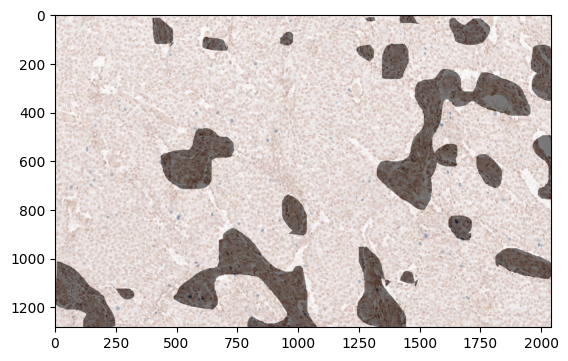

In [47]:
testImage = cv2.imread(str(images_paths[img_idx]))
testMask = cv2.imread(str(masks_paths[img_idx]))

plt.imshow(testImage)
plt.imshow(testMask, alpha=0.5)

### Mask prediction

In [48]:
if compute == True:
  avg = predict(model, device, testImage)

else:
  avg = get_prediction(
      model, local_path, project_path, version)

Row 0/ 1300
Row 200/ 1300
Row 400/ 1300
Row 600/ 1300
Row 800/ 1300
Row 1000/ 1300
Row 1200/ 1300


### Mask predition saving

In [49]:
if avg_write == True:
  cv2.imwrite('avg.png', avg*255)

Visualisations

Raw output of the segmentation:

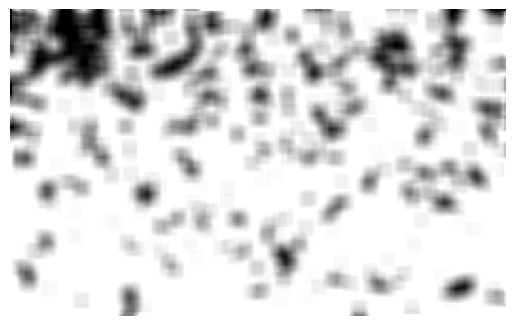

In [50]:
raw_output = beautify_output(avg)
visualise_output(raw_output)

Thresholded output:

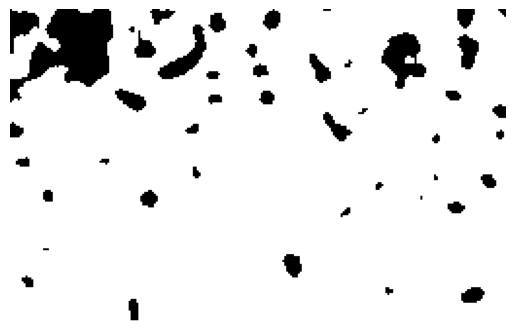

In [51]:
thr = 0.50 # threshold

thr_output = threshold_output(avg, thr)
visualise_output(thr_output)

Prediction saving:

In [52]:
if output_write == True:
	save_prediction(thr_output)

# Evaluation

###Metrics

In [53]:
tumor = True

In [54]:
y_true = get_true_labels(testMask, tumor)
y_pred = get_pred_labels(thr_output, tumor)

Compute metrics:
- Accuracy
- ...

In [55]:
acc = pixel_accuracy(y_true, y_pred)
prec = pixel_precision(y_true, y_pred)
recall = pixel_recall(y_true, y_pred)
iou = intersection_over_union(y_true, y_pred)
dice = dice_coefficient(y_true, y_pred)

Show metric table:

In [56]:
show_metrics(acc, prec, recall, iou, dice)

+-----------------+---------+
| Metric          |   Value |
+=================+=========+
| Pixel Accuracy  |  0.7485 |
+-----------------+---------+
| Pixel Precision |  0.8167 |
+-----------------+---------+
| Pixel Recall    |  0.8976 |
+-----------------+---------+
| IoU             |  0.7471 |
+-----------------+---------+
| Dice Coeff.     |  0.8552 |
+-----------------+---------+


### Confusion matrix:

In [57]:
type(conf_matrix)

function

In [58]:
conf_m = conf_matrix(y_true, y_pred)
conf_norm_m = conf_matrix(y_true, y_pred, normalise="true")

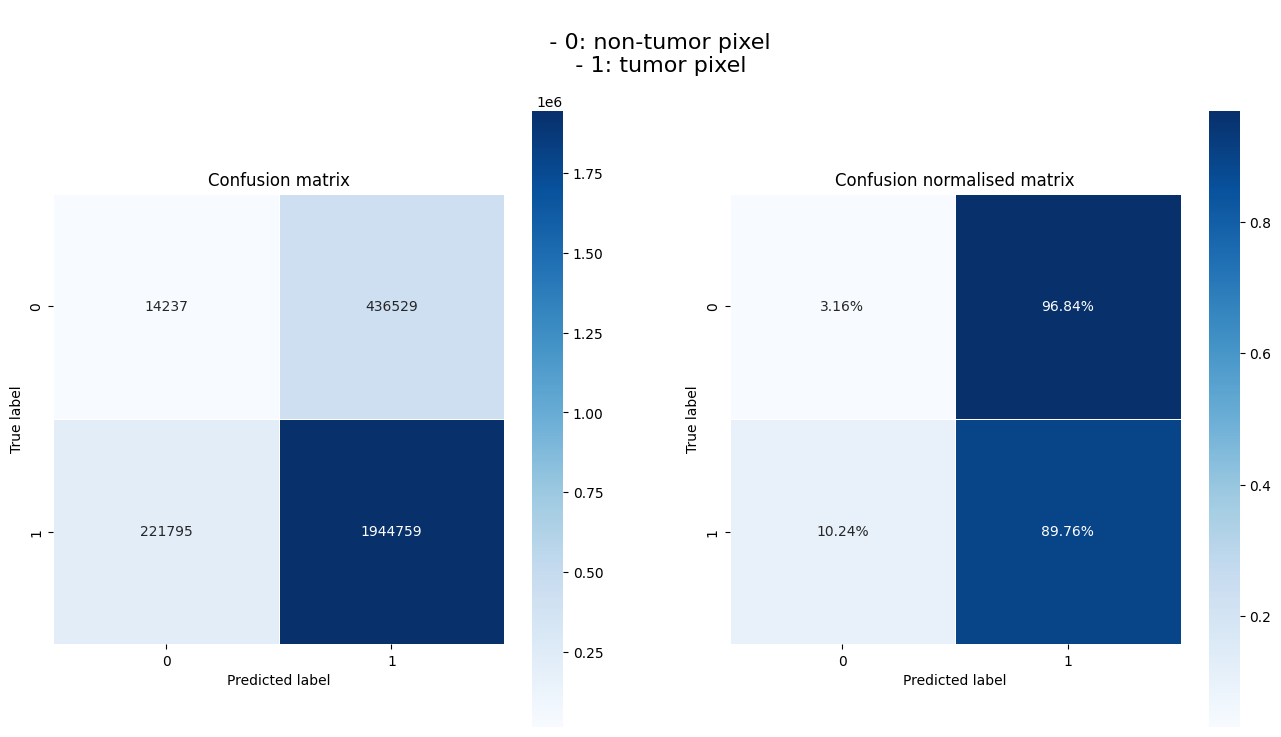

In [59]:
show_conf_matrices(conf_m, conf_norm_m)

### Visualisation

Visualisation of prediction border onto input image:

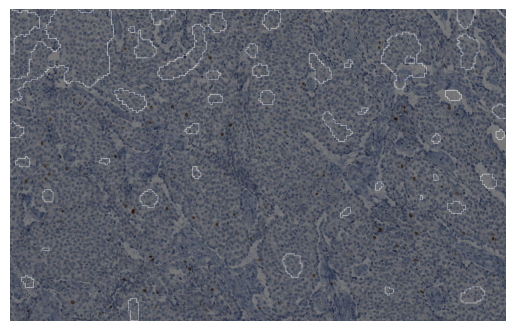

In [60]:
visualize_bordered_mask(testImage, thr_output, radius=2)